C:\Users\abdulssekyanzi\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\layers\convolutional\base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 1/50
77/77 ━━━━━━━━━━━━━━━━━━━━ 34s 200ms/step - accuracy: 0.6534 - loss: 0.6358 - val_accuracy: 0.6639 - val_loss: 0.6420
Epoch 2/50
77/77 ━━━━━━━━━━━━━━━━━━━━ 13s 170ms/step - accuracy: 0.6775 - loss: 0.6082 - val_accuracy: 0.6639 - val_loss: 0.6386
Epoch 3/50
77/77 ━━━━━━━━━━━━━━━━━━━━ 21s 165ms/step - accuracy: 0.6651 - loss: 0.6279 - val_accuracy: 0.6639 - val_loss: 0.6419
Epoch 4/50
77/77 ━━━━━━━━━━━━━━━━━━━━ 13s 169ms/step - accuracy: 0.6850 - loss: 0.6082 - val_accuracy: 0.6639 - val_loss: 0.6380
Epoch 5/50
77/77 ━━━━━━━━━━━━━━━━━━━━ 20s 161ms/step - accuracy: 0.6879 - loss: 0.6089 - val_accuracy: 0.6639 - val_loss: 0.6386
Epoch 6/50
77/77 ━━━━━━━━━━━━━━━━━━━━ 22s 171ms/step - accuracy: 0.6641 - loss: 0.6187 - val_accuracy: 0.6639 - val_loss: 0.6433
Epoch 7/50
77/77 ━━━━━━━━━━━━━━━━━━━━ 20s 166ms/step - accuracy: 0.6750 - loss: 0.6073 - val_accuracy: 0.6639 - val_loss: 0.6347
Epoch 8/50
77/77 ━━━━━━━━━━━━━━━━━━━━ 23s 199ms/step - accuracy: 0.6718 - loss: 0.6083 - val_accu

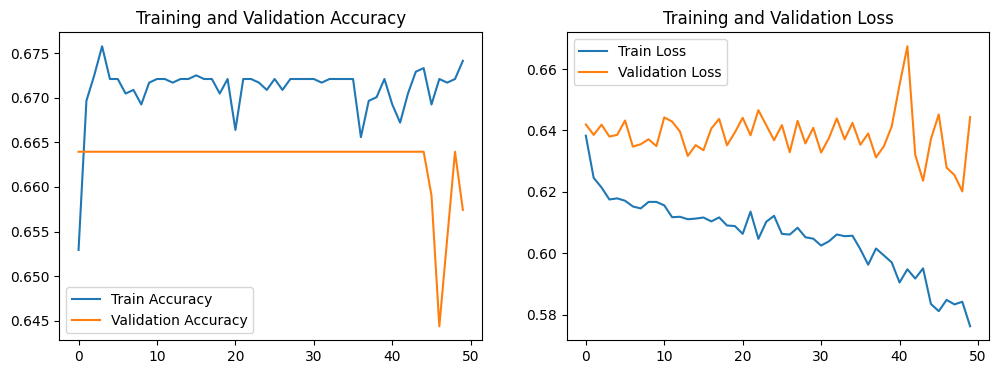

24/24 ━━━━━━━━━━━━━━━━━━━━ 2s 90ms/step - accuracy: 0.6369 - loss: 0.6007 
Test Accuracy: 0.6388526558876038
24/24 ━━━━━━━━━━━━━━━━━━━━ 6s 157ms/step

Classification Report:
              precision    recall  f1-score   support

           0       0.22      0.01      0.03       267
           1       0.65      0.97      0.78       500

    accuracy                           0.64       767
   macro avg       0.44      0.49      0.40       767
weighted avg       0.50      0.64      0.52       767



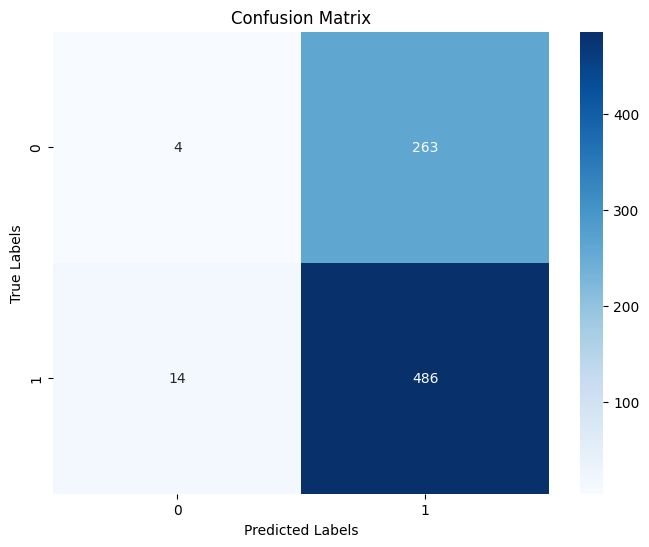

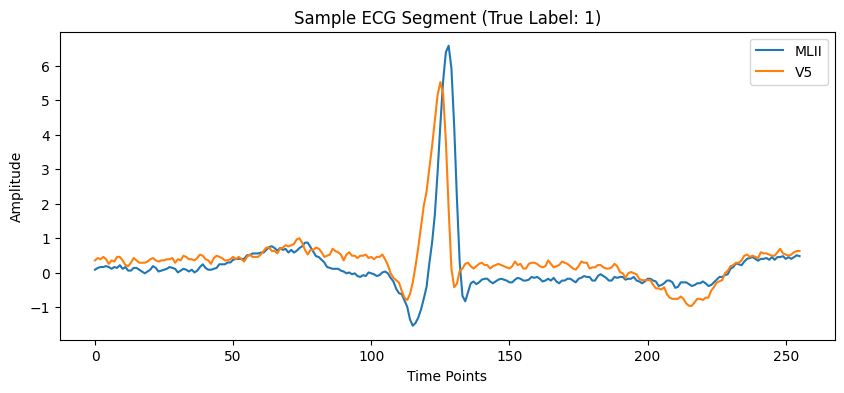

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv1D, MaxPooling1D, LSTM, Dense, Dropout, BatchNormalization
from tensorflow.keras.optimizers import Adam
from scipy.signal import find_peaks
from sklearn.preprocessing import StandardScaler
from tensorflow.keras.utils import to_categorical
from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns

# 1. Data Preprocessing (Modified)
def preprocess_ecg(file_path, segment_length=256):
    df = pd.read_csv(file_path)
    df = df.drop("Unnamed: 0", axis=1)

    mlii = df['MLII'].values
    v5 = df['V5'].values
    time_ms = df['time_ms'].values

    peaks, _ = find_peaks(np.abs(mlii), distance=150)

    segments = []
    for peak in peaks:
        start = max(0, peak - segment_length // 2)
        end = min(len(mlii), peak + segment_length // 2)
        if end - start == segment_length:
            segment = np.stack((mlii[start:end], v5[start:end]), axis=-1)
            segments.append(segment)

    return np.array(segments)

# Load only arrhythmia data (as you don't have normal data)
arrhythmia_data = preprocess_ecg('C:/Users/abdulssekyanzi/EDA Dataset.csv/100.csv')  # Replace with your file

# Simulate "normal" data from a subset of the arrhythmia data
# This is a VERY rough approximation and not ideal.
# It is best to get real normal data.
simulated_normal_data = arrhythmia_data[:len(arrhythmia_data) // 2] # take first half.

# Create labels (0 for simulated normal, 1 for arrhythmia)
simulated_normal_labels = np.zeros(len(simulated_normal_data))
arrhythmia_labels = np.ones(len(arrhythmia_data))

# Combine data and labels
X = np.concatenate((simulated_normal_data, arrhythmia_data))
y = np.concatenate((simulated_normal_labels, arrhythmia_labels))

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.2, random_state=42)

scaler = StandardScaler()
X_train = scaler.fit_transform(X_train.reshape(-1, X_train.shape[-1])).reshape(X_train.shape)
X_val = scaler.transform(X_val.reshape(-1, X_val.shape[-1])).reshape(X_val.shape)
X_test = scaler.transform(X_test.reshape(-1, X_test.shape[-1])).reshape(X_test.shape)

y_train_categorical = to_categorical(y_train)
y_val_categorical = to_categorical(y_val)
y_test_categorical = to_categorical(y_test)

# 2. Model Building (same as before)
model = Sequential([
    Conv1D(filters=64, kernel_size=5, activation='relu', input_shape=(X_train.shape[1], X_train.shape[2])),
    BatchNormalization(),
    MaxPooling1D(pool_size=2),
    Conv1D(filters=128, kernel_size=3, activation='relu'),
    BatchNormalization(),
    MaxPooling1D(pool_size=2),
    LSTM(128, return_sequences=True),
    LSTM(64),
    Dense(64, activation='relu'),
    Dropout(0.5),
    Dense(2, activation='softmax')
])

model.compile(optimizer=Adam(learning_rate=0.001), loss='categorical_crossentropy', metrics=['accuracy'])

# 3. Model Training (same as before)
history = model.fit(X_train, y_train_categorical, epochs=50, validation_data=(X_val, y_val_categorical), batch_size=32, verbose=1)

# Plot training history (same as before)
plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.legend()
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.legend()
plt.title('Training and Validation Loss')
plt.show()

# 4. Model Evaluation (same as before)
loss, accuracy = model.evaluate(X_test, y_test_categorical)
print(f"Test Accuracy: {accuracy}")

# Classification Report and Confusion Matrix (same as before)
y_pred = model.predict(X_test)
y_pred_classes = np.argmax(y_pred, axis=1)
y_true = np.argmax(y_test_categorical, axis=1)

print("\nClassification Report:")
print(classification_report(y_true, y_pred_classes))

cm = confusion_matrix(y_true, y_pred_classes)
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title('Confusion Matrix')
plt.show()

# Example of plotting a sample ECG segment (same as before)
sample_index = 0
sample_segment = X_test[sample_index]
plt.figure(figsize=(10, 4))
plt.plot(sample_segment[:, 0], label='MLII')
plt.plot(sample_segment[:, 1], label='V5')
plt.title(f'Sample ECG Segment (True Label: {y_true[sample_index]})')
plt.xlabel('Time Points')
plt.ylabel('Amplitude')
plt.legend()
plt.show()